# Understanding Qwen2-VL Model - Deep Dive 🔍

**Purpose**: This notebook provides a comprehensive understanding of the Qwen2-VL model through:
- Tokenizer analysis and special tokens
- Model architecture and configuration
- Inference pipeline demonstration
- Output parsing and visualization
- Pre-trained model capabilities testing

**When to use this notebook**:
- Before starting fine-tuning (understand what you're working with)
- When debugging inference issues
- To compare pre-trained vs fine-tuned model performance

**Educational Goals**:
1. Understand the input format required by Qwen2-VL
2. Learn how `apply_chat_template` works
3. Understand `process_vision_info` function
4. Explore the processor's functionalities
5. Test pre-trained model capabilities on nutrition tables

## 📚 Background Reading

Before diving into the code, you should familiarize yourself with:

- **Qwen2-VL Paper**: Understand the model architecture and design choices
- **Model Card on Hugging Face**: Learn about capabilities and limitations
- **Chat Template Format**: How conversation-style inputs are structured

### Key Questions to Explore:

1. **Input Format**:
   - Can you create an example input with multiple images and videos?
   - How does the model distinguish between different media types?

2. **`apply_chat_template`**:
   - What does this function do to your messages?
   - How does it format the conversation for the model?

3. **`process_vision_info`**:
   - What does this function return?
   - How are images processed before tokenization?

4. **`processor()`**:
   - How does patch-ification work?
   - What happens during text tokenization?
   - How are vision and text tokens combined?

5. **[Optional] Analyze `model.generate()`'s [forward pass](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L999):**
  - Understand its operations, including:
    - Embedding image patches through `PatchEmbed`’s [forward pass](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L272).
    - Sending patch embeddings to a transformer for feature extraction:
      - Grasp the concept of 2D RoPE (Rotary Position Embedding).
      - Pay attention to [forbidden attention](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L339) when more than one image is provided.
    - Merging the resulting feature embeddings via [PatchMerger](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L298).
    - Processing image and text embeddings using the LLM:
      - Pay special attention to multimodal RoPE.

## 1. Tokenizer Analysis 🔤

The tokenizer is crucial for understanding how text and special tokens are processed.
Qwen2-VL uses special tokens for vision information (images/videos) and bounding boxes.

In [1]:
# Import necessary libraries
from transformers import Qwen2VLProcessor
import json

print("\n" + "=" * 80)
print("TOKENIZER ANALYSIS - Understanding Special Tokens and Configuration")
print("=" * 80)

# Load the processor and tokenizer with optimized pixel configuration
processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=256*28*28,    # ~200k pixels (reduced from 3k default)
    max_pixels=1280*28*28,   # ~1M pixels (reduced from 12.8M default!)
    trust_remote_code=True
)
tokenizer = processor.tokenizer

print("\n1. VOCABULARY INFORMATION:")
print("-" * 40)
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Model max length: {tokenizer.model_max_length}")
print(f"Padding side: {tokenizer.padding_side}")
print(f"Truncation side: {tokenizer.truncation_side}")
print(f"len(tokenizer): {len(tokenizer)}")

print("\n2. SPECIAL TOKENS MAP:")
print("-" * 40)
special_tokens_map = tokenizer.special_tokens_map
for token_name, token_value in special_tokens_map.items():
    token_id = tokenizer.convert_tokens_to_ids(token_value) if isinstance(token_value, str) else None
    print(f"{token_name}: '{token_value}' -> ID: {token_id}")

print("\n3. ALL SPECIAL TOKENS:")
print("-" * 40)
all_special_tokens = tokenizer.all_special_tokens
print(f"Total special tokens: {len(all_special_tokens)}")
for i, token in enumerate(all_special_tokens[:20]):  # Show first 20
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"  {i+1}. '{token}' -> ID: {token_id}")
if len(all_special_tokens) > 20:
    print(f"  ... and {len(all_special_tokens) - 20} more")

print("\n4. IMPORTANT TOKEN IDS:")
print("-" * 40)
print(f"pad_token_id: {tokenizer.pad_token_id} ('{tokenizer.pad_token}' if exists)")
print(f"bos_token_id: {tokenizer.bos_token_id} ('{tokenizer.bos_token}' if exists)")
print(f"eos_token_id: {tokenizer.eos_token_id} ('{tokenizer.eos_token}' if exists)")
print(f"unk_token_id: {tokenizer.unk_token_id} ('{tokenizer.unk_token}' if exists)")

# Check for vision-specific tokens
print("\n5. VISION-SPECIFIC TOKENS:")
print("-" * 40)
vision_tokens = ["<|vision_start|>", "<|vision_end|>", "<|image_pad|>", "<|video_pad|>",
                 "<|object_ref_start|>", "<|object_ref_end|>", "<|box_start|>", "<|box_end|>",
                 "<|im_start|>", "<|im_end|>"]
for token in vision_tokens:
    if token in tokenizer.get_vocab():
        token_id = tokenizer.convert_tokens_to_ids(token)
        print(f"'{token}' -> ID: {token_id}")
    else:
        print(f"'{token}' -> NOT IN VOCABULARY")

print("\n6. CHAT TEMPLATE:")
print("-" * 40)
if hasattr(tokenizer, 'chat_template'):
    print("Chat template exists:")
    # Print first 500 chars of template
    template_str = str(tokenizer.chat_template)[:500]
    print(template_str + "..." if len(str(tokenizer.chat_template)) > 500 else template_str)
else:
    print("No chat template found")

print("\n7. TOKEN ID RANGE CHECK:")
print("-" * 40)
print(f"Valid token ID range: 0 to {tokenizer.vocab_size - 1}")
print(f"Any token ID >= {tokenizer.vocab_size} will cause training errors!")

/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(



TOKENIZER ANALYSIS - Understanding Special Tokens and Configuration


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.



1. VOCABULARY INFORMATION:
----------------------------------------
Vocabulary size: 151643
Model max length: 32768
Padding side: left
Truncation side: right
len(tokenizer): 151657

2. SPECIAL TOKENS MAP:
----------------------------------------
eos_token: '<|im_end|>' -> ID: 151645
pad_token: '<|endoftext|>' -> ID: 151643
additional_special_tokens: '['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']' -> ID: None

3. ALL SPECIAL TOKENS:
----------------------------------------
Total special tokens: 14
  1. '<|im_end|>' -> ID: 151645
  2. '<|endoftext|>' -> ID: 151643
  3. '<|im_start|>' -> ID: 151644
  4. '<|object_ref_start|>' -> ID: 151646
  5. '<|object_ref_end|>' -> ID: 151647
  6. '<|box_start|>' -> ID: 151648
  7. '<|box_end|>' -> ID: 151649
  8. '<|quad_start|>' -> ID: 151650
  9. '<|quad_end|>' -> 

### 💡 Key Takeaways from Tokenizer Analysis:

1. **Special Tokens**: Qwen2-VL uses many special tokens for vision tasks:
   - `<|vision_start|>`, `<|vision_end|>`: Mark vision content
   - `<|image_pad|>`, `<|video_pad|>`: Padding for images/videos
   - `<|object_ref_start|>`, `<|object_ref_end|>`: Reference detected objects
   - `<|box_start|>`, `<|box_end|>`: Enclose bounding box coordinates

2. **Coordinate Space**: Qwen2-VL uses normalized coordinates in [0, 1000] range

3. **Token ID Range**: Critical for training - any token ID beyond vocab_size causes errors!

## 2. Model Loading and Configuration ⚙️

Let's load the model and verify its configuration matches the tokenizer.

In [2]:
import torch
import transformers
from transformers import Qwen2VLForConditionalGeneration

print("\n" + "=" * 80)
print("MODEL LOADING AND VERIFICATION")
print("=" * 80)

# Load model with appropriate precision and optimizations
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,  # Original training precision (from config.json)
    attn_implementation="flash_attention_2",  # Faster and more memory-efficient
    device_map="cuda"
)

# Collect tokenizer statistics
tok_vocab_size = tokenizer.vocab_size
tok_len        = len(tokenizer)
added_vocab    = tokenizer.get_added_vocab()
n_added        = len(added_vocab)

# Collect model statistics
emb_in  = model.get_input_embeddings().weight.shape[0]
emb_out = (model.get_output_embeddings().weight.shape[0]
           if model.get_output_embeddings() is not None else None)
cfg_vocab = getattr(model.config, "vocab_size", None)

print("\n---- TOKENIZER ----")
print(f"tokenizer.vocab_size : {tok_vocab_size}")
print(f"len(tokenizer)       : {tok_len}  (added tokens: {n_added})")

print("\n---- MODEL ----")
print(f"config.vocab_size    : {cfg_vocab}")
print(f"input emb rows       : {emb_in}")
print(f"lm_head rows         : {emb_out}")
print(f"config class         : {model.config.__class__.__name__}")

# Verify consistency
print("\n---- CONSISTENCY CHECK ----")
if tok_len == emb_in == emb_out:
    print("✅ PASS: Tokenizer and model embeddings are consistent!")
else:
    print("❌ WARNING: Inconsistency detected!")
    print(f"   Tokenizer length: {tok_len}")
    print(f"   Input embeddings: {emb_in}")
    print(f"   Output embeddings: {emb_out}")


MODEL LOADING AND VERIFICATION


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]


---- TOKENIZER ----
tokenizer.vocab_size : 151643
len(tokenizer)       : 151657  (added tokens: 14)

---- MODEL ----
config.vocab_size    : 152064
input emb rows       : 152064
lm_head rows         : 152064
config class         : Qwen2VLConfig

---- CONSISTENCY CHECK ----
❌ WARNING: Inconsistency detected!
   Tokenizer length: 151657
   Input embeddings: 152064
   Output embeddings: 152064


### 💡 Why This Consistency Check Matters:

- **Embedding Size**: Must match between tokenizer and model
- **Training Issues**: Mismatch causes IndexError during training
- **Special Tokens**: Adding tokens requires resizing embeddings

If you add custom tokens, you must call `model.resize_token_embeddings(len(tokenizer))`

## 3. Inference Function 🚀

Now let's create a complete inference pipeline that handles:
1. Image loading (from path or PIL Image)
2. Message formatting (conversation structure)
3. Chat template application
4. Vision processing
5. Model generation
6. Output decoding

In [3]:
from qwen_vl_utils import process_vision_info

def run_qwen2vl_inference(image_path_or_pil, prompt, model_id="Qwen/Qwen2-VL-7B-Instruct",
                          device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Run inference with Qwen2-VL model.

    Args:
        image_path_or_pil: Either a file path to an image or a PIL Image object
        prompt: Text prompt for the model
        model_id: Model identifier from HuggingFace
        device: Device to run inference on

    Returns:
        Generated text response from the model

    Example Usage:
        >>> from PIL import Image
        >>> image = Image.open("product.jpg")
        >>> result = run_qwen2vl_inference(image, "Detect the nutrition table")
        >>> print(result)  # "nutrition table(x1,y1),(x2,y2)"
    """
    # Load model and processor
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        device_map=device
    )
    processor = Qwen2VLProcessor.from_pretrained(
        model_id,
        min_pixels=256*28*28,    # ~200k pixels
        max_pixels=1280*28*28,   # ~1M pixels
        trust_remote_code=True
    )

    # Set model to evaluation mode
    model.eval()

    # Handle image input - can be path or PIL Image
    if isinstance(image_path_or_pil, str):
        from PIL import Image
        image = Image.open(image_path_or_pil)
    else:
        image = image_path_or_pil

    # Create conversation format expected by Qwen2-VL
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    # Apply chat template to format the conversation
    text = processor.apply_chat_template(
        messages,
        tokenize=False,  #  if tokenize=True, the text will be tokenized and the tokens will be returned. if tokenize=False, the text will be returned as is
        add_generation_prompt=True  # Add assistant token to prompt response
    )

    # Process vision information (handles image resizing, patching, etc.)
    image_inputs, video_inputs = process_vision_info(messages)

    # Prepare inputs for the model
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(device)

    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,  # Deterministic for object detection
        )

    # Decode only the generated tokens (excluding the input)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]

    return output_text

print("✅ Inference function defined successfully!")

✅ Inference function defined successfully!


### 🔍 Understanding the Inference Pipeline:

1. **Message Format**: List of dicts with 'role' and 'content'
2. **Content Types**: Can include 'image', 'video', and 'text' types
3. **Chat Template**: Converts messages to model-specific format
4. **Vision Processing**: Handles image resizing, patching
5. **Token Trimming**: Only decode generated tokens, not input

## 4. Testing Inference on Red Car Example 🚗

Let's test the inference function with a simple example before moving to nutrition tables.


📷 DISPLAYING ORIGINAL TEST IMAGE:


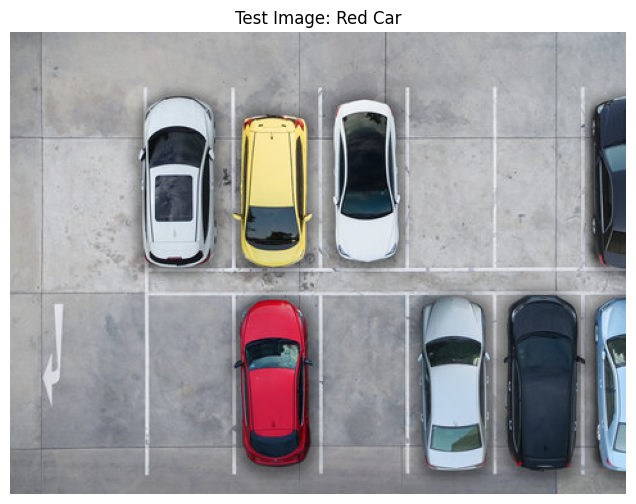


Testing Qwen2-VL inference...
Prompt: 'Detect the bounding box of the red car.'


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Model Response:
the red car(361,571),(491,935)

📝 Expected Output Formats:
  WITH special tokens (skip_special_tokens=False):
    <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
  Where coordinates are normalized to image dimensions (1000x1000 for Qwen2-VL)

  WITHOUT special tokens (skip_special_tokens=True):
    the red car(x1,y1),(x2,y2)

Output now looks like expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)


In [4]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Download test image
test_image_url = "https://t4.ftcdn.net/jpg/01/57/82/05/360_F_157820583_agejYX5XeczPZuWRSCDF2YYeCGwJqUdG.jpg"
response = requests.get(test_image_url)
test_image = Image.open(BytesIO(response.content))

# Display the test image
print("\n📷 DISPLAYING ORIGINAL TEST IMAGE:")
plt.figure(figsize=(8, 6))
plt.imshow(test_image)
plt.title("Test Image: Red Car")
plt.axis('off')
plt.show()

# Test the inference function
print("\n" + "=" * 60)
print("Testing Qwen2-VL inference...")
print("Prompt: 'Detect the bounding box of the red car.'")

result = run_qwen2vl_inference(
    test_image,
    "Detect the bounding box of the red car."
)
print("\nModel Response:")
print(result)
print("=" * 60)

# Show expected output formats
print("\n📝 Expected Output Formats:")
print("  WITH special tokens (skip_special_tokens=False):")
print("    <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>")
print("  Where coordinates are normalized to image dimensions (1000x1000 for Qwen2-VL)")
print("\n  WITHOUT special tokens (skip_special_tokens=True):")
print("    the red car(x1,y1),(x2,y2)")

print("\n" + "=" * 60)
print("Output now looks like expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)")

## 5. Parsing Model Output 📊

The model outputs bounding boxes in a specific format. We need a parser to extract:
1. Object name (what was detected)
2. Bounding box coordinates (where it is)

In [5]:
import re

def parse_qwen_bbox_output(model_output):
    """
    Parse Qwen2-VL model output to extract bounding box coordinates.

    Args:
        model_output: String output from the model

    Returns:
        Dict with 'object' name and 'bbox' coordinates, or list of dicts for multiple detections,
        or None if parsing fails

    Supported Formats:
        1. WITH special tokens (skip_special_tokens=False):
           "<|object_ref_start|>object name<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>"

        2. WITHOUT special tokens (skip_special_tokens=True):
           "object name(x1,y1),(x2,y2)"

    Returns:
        Single detection: {'object': 'car', 'bbox': [x1, y1, x2, y2]}
        Multiple detections: [{'object': 'car', 'bbox': [...]}, {'object': 'table', 'bbox': [...]}]

    Example:
        >>> output = "the red car(358,571),(492,943)"
        >>> parse_qwen_bbox_output(output)
        {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
    """
    # Remove <|im_end|> token if present
    model_output = model_output.replace('<|im_end|>', '').strip()

    # Pattern 1: WITH special tokens (skip_special_tokens=False)
    pattern_with_tokens = r'<\|object_ref_start\|>(.+?)<\|object_ref_end\|><\|box_start\|>\((\d+),(\d+)\),\((\d+),(\d+)\)<\|box_end\|>'
    matches = re.findall(pattern_with_tokens, model_output)

    if matches:
        results = []
        for match in matches:
            object_name = match[0]
            x1, y1, x2, y2 = int(match[1]), int(match[2]), int(match[3]), int(match[4])
            results.append({
                'object': object_name,
                'bbox': [x1, y1, x2, y2]  # Qwen outputs in [x,y,x,y] format
            })
        return results[0] if len(results) == 1 else results

    # Pattern 2: WITHOUT special tokens (skip_special_tokens=True)
    pattern_no_tokens = r'([^\(]+?)\s*\((\d+),(\d+)\),\((\d+),(\d+)\)'
    matches = re.findall(pattern_no_tokens, model_output)

    if matches:
        results = []
        for match in matches:
            object_name = match[0].strip()
            x1, y1, x2, y2 = int(match[1]), int(match[2]), int(match[3]), int(match[4])
            results.append({
                'object': object_name,
                'bbox': [x1, y1, x2, y2]
            })
        return results[0] if len(results) == 1 else results

    return None  # No valid bbox found

# Test the parsing function
print("\n📝 Testing parse_qwen_bbox_output function:")
print("=" * 50)

# Test 1: WITH special tokens
test_with_tokens = "<|object_ref_start|>the red car<|object_ref_end|><|box_start|>(450,380),(650,520)<|box_end|><|im_end|>"
parsed1 = parse_qwen_bbox_output(test_with_tokens)
print(f"Test 1 - WITH special tokens:")
print(f"  Input: {test_with_tokens}")
print(f"  Parsed: {parsed1}")
print(f"  ✅ Correctly extracts object and bbox")

# Test 2: WITHOUT special tokens
test_no_tokens = "the red car(358,571),(492,943)"
parsed2 = parse_qwen_bbox_output(test_no_tokens)
print(f"\nTest 2 - WITHOUT special tokens:")
print(f"  Input: {test_no_tokens}")
print(f"  Parsed: {parsed2}")
print(f"  ✅ Correctly extracts object and bbox")

# Test 3: Real example with extra text
test_nutrition = "The nutrition table(13,60),(984,989) is located in the image"
parsed3 = parse_qwen_bbox_output(test_nutrition)
print(f"\nTest 3 - With extra text:")
print(f"  Input: {test_nutrition}")
print(f"  Parsed: {parsed3}")
if parsed3:
    print(f"  ✅ Successfully parsed even with extra text")
else:
    print(f"  ❌ Failed to parse")

print("=" * 50)


📝 Testing parse_qwen_bbox_output function:
Test 1 - WITH special tokens:
  Input: <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(450,380),(650,520)<|box_end|><|im_end|>
  Parsed: {'object': 'the red car', 'bbox': [450, 380, 650, 520]}
  ✅ Correctly extracts object and bbox

Test 2 - WITHOUT special tokens:
  Input: the red car(358,571),(492,943)
  Parsed: {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
  ✅ Correctly extracts object and bbox

Test 3 - With extra text:
  Input: The nutrition table(13,60),(984,989) is located in the image
  Parsed: {'object': 'The nutrition table', 'bbox': [13, 60, 984, 989]}
  ✅ Successfully parsed even with extra text


## 6. Visualization Function 🎨

Let's create a function to visualize bounding boxes on images.

In [6]:
from PIL import ImageDraw, ImageFont

def visualize_bbox_on_image(image, bbox_data, normalize_coords=True):
    """
    Visualize bounding boxes on an image.

    Args:
        image: PIL Image object
        bbox_data: Dict or list of dicts with 'object' and 'bbox' keys
        normalize_coords: If True, bbox coords are in [0,1000] space (from model)
                         If False, bbox coords are already in pixel coordinates

    Returns:
        PIL Image with bounding boxes drawn

    Example:
        >>> bbox_data = {'object': 'car', 'bbox': [358, 571, 492, 943]}
        >>> img_with_bbox = visualize_bbox_on_image(image, bbox_data, normalize_coords=True)
    """
    # Make a copy to avoid modifying original
    img_with_bbox = image.copy()
    draw = ImageDraw.Draw(img_with_bbox)
    width, height = img_with_bbox.size

    # Handle None case
    if bbox_data is None:
        print("No bounding box data to visualize")
        return img_with_bbox

    # Handle single or multiple bboxes
    if isinstance(bbox_data, dict):
        bbox_data = [bbox_data]

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

    for idx, data in enumerate(bbox_data):
        if data is None:
            continue

        color = colors[idx % len(colors)]
        bbox = data['bbox']
        object_name = data.get('object', 'unknown')

        # Convert coordinates if needed
        if normalize_coords:
            # Qwen uses 1000x1000 normalized space
            x1 = int(bbox[0] * width / 1000)
            y1 = int(bbox[1] * height / 1000)
            x2 = int(bbox[2] * width / 1000)
            y2 = int(bbox[3] * height / 1000)
        else:
            x1, y1, x2, y2 = bbox

        # Ensure coordinates are integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)

        # Add label with background
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = None

        label = f"{object_name}"
        if font:
            bbox_label = draw.textbbox((x1, y1-30), label, font=font)
            draw.rectangle(bbox_label, fill=color)
            draw.text((x1, y1-30), label, fill='white', font=font)
        else:
            draw.text((x1, y1-25), label, fill=color)

        print(f"Drew bbox in pixels for '{object_name}': [{x1}, {y1}, {x2}, {y2}]")

    return img_with_bbox

print("✅ Visualization function defined successfully!")

✅ Visualization function defined successfully!


## 7. Visualizing Red Car Detection 🚗

Let's visualize the red car detection we ran earlier.


VISUALIZING RED CAR DETECTION
Model output: the red car(358,571),(492,943)
Parsed bbox: {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
Drew bbox in pixels for 'the red car': [171, 205, 236, 339]


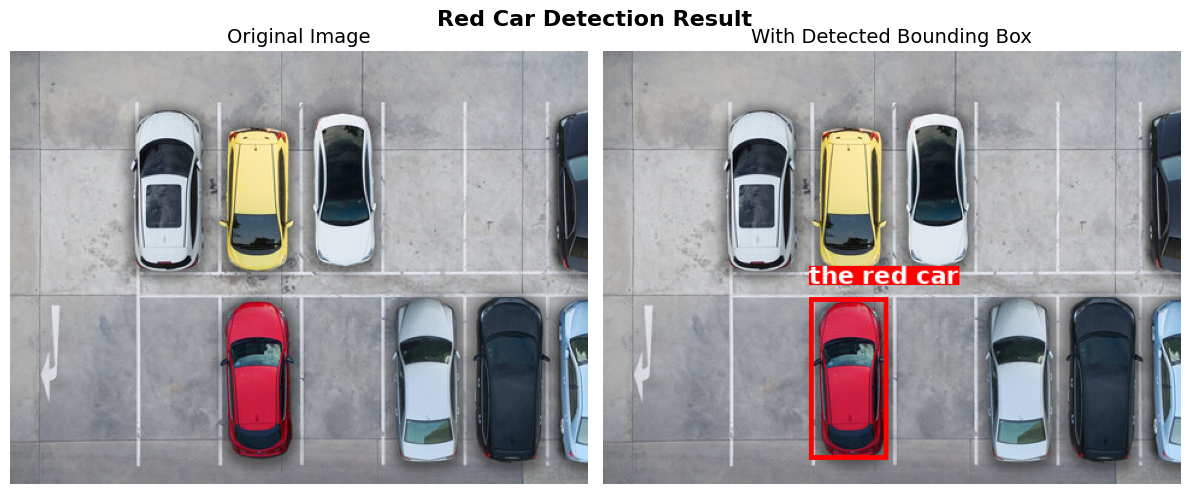

In [7]:
print("\n" + "=" * 60)
print("VISUALIZING RED CAR DETECTION")
print("=" * 60)

# We already have the result
red_car_output = "the red car(358,571),(492,943)"
print(f"Model output: {red_car_output}")

# Parse and visualize
parsed_red_car = parse_qwen_bbox_output(red_car_output)
print(f"Parsed bbox: {parsed_red_car}")

if parsed_red_car:
    img_with_bbox = visualize_bbox_on_image(test_image, parsed_red_car, normalize_coords=True)

    # Display comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(test_image)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(img_with_bbox)
    axes[1].set_title("With Detected Bounding Box", fontsize=14)
    axes[1].axis('off')

    plt.suptitle("Red Car Detection Result", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. Testing Pre-trained Model on Nutrition Tables 🍏

Now let's test the pre-trained model on nutrition table detection.
This will help us understand:
1. Current model capabilities (without fine-tuning)
2. Where the model struggles
3. Why fine-tuning is necessary

In [8]:
# First, load the dataset
from datasets import load_dataset

print("\n📦 Loading OpenFoodFacts nutrition-table-detection dataset...")
dataset = load_dataset("openfoodfacts/nutrition-table-detection", split="train", streaming=False)
print(f"✅ Dataset loaded: {len(dataset)} training examples")

# Get the first example
example_idx = 0
example = dataset[example_idx]
nutrition_image = example['image']
ground_truth_bbox = example['objects']['bbox'][0]
ground_truth_category = example['objects']['category_name'][0]

print(f"\nUsing training example #{example_idx}")
print(f"Image size: {nutrition_image.size}")
print(f"Ground truth category: {ground_truth_category}")
print(f"Ground truth bbox (normalized): {ground_truth_bbox}")


📦 Loading OpenFoodFacts nutrition-table-detection dataset...
✅ Dataset loaded: 1083 training examples

Using training example #0
Image size: (2592, 1944)
Ground truth category: nutrition-table
Ground truth bbox (normalized): [0.057098764926195145, 0.014274691231548786, 0.603501558303833, 0.991126537322998]


### 🎯 Run Inference on Nutrition Table

In [9]:
print("\n" + "=" * 60)
print("TESTING PRE-TRAINED MODEL ON NUTRITION TABLE")
print("=" * 60)

# Run inference
print("\nRunning inference...")
nutrition_response = run_qwen2vl_inference(
    nutrition_image,
    "Detect the bounding box of the nutrition table."
)
print(f"Model response: {nutrition_response}")

# Parse the output
parsed_nutrition = parse_qwen_bbox_output(nutrition_response)
print(f"Parsed bbox: {parsed_nutrition}")


TESTING PRE-TRAINED MODEL ON NUTRITION TABLE

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: The nutrition table(10,45),(989,585) is located in the top left corner of the image, spanning from the top left to the bottom right.
Parsed bbox: {'object': 'The nutrition table', 'bbox': [10, 45, 989, 585]}


### 📊 Compare Ground Truth vs Prediction

Drew bbox in pixels for 'The nutrition table': [25, 87, 2563, 1137]


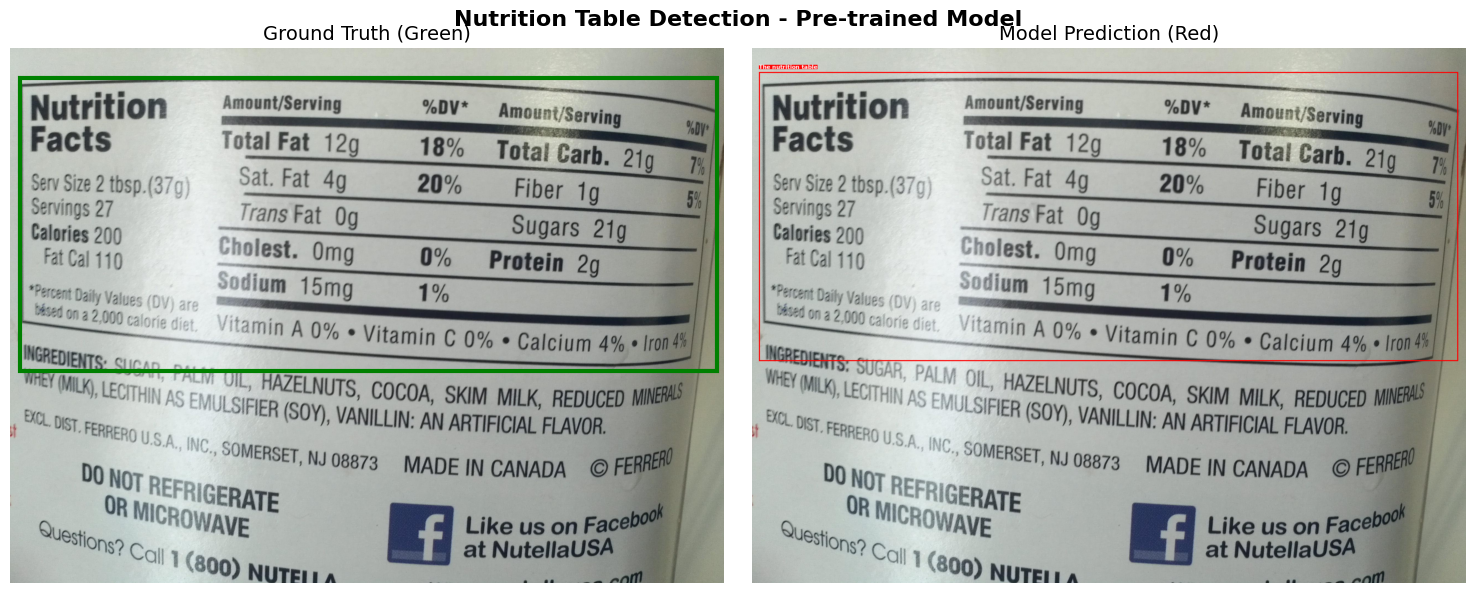

In [10]:
if parsed_nutrition:
    # Visualize prediction
    img_with_nutrition_bbox = visualize_bbox_on_image(nutrition_image, parsed_nutrition, normalize_coords=True)

    # Create comparison visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Left: Ground truth
    axes[0].imshow(nutrition_image)
    pil_width, pil_height = nutrition_image.size

    # CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
    y_min, x_min, y_max, x_max = ground_truth_bbox
    gt_x1 = int(x_min * pil_width)
    gt_y1 = int(y_min * pil_height)
    gt_x2 = int(x_max * pil_width)
    gt_y2 = int(y_max * pil_height)

    from matplotlib.patches import Rectangle
    rect = Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                     linewidth=3, edgecolor='green', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title("Ground Truth (Green)", fontsize=14)
    axes[0].axis('off')

    # Right: Model prediction
    axes[1].imshow(img_with_nutrition_bbox)
    axes[1].set_title("Model Prediction (Red)", fontsize=14)
    axes[1].axis('off')

    plt.suptitle("Nutrition Table Detection - Pre-trained Model", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Failed to parse bbox - the model likely couldn't detect the nutrition table.")

## 9. Testing on Multiple Bounding Box Examples 📦

Some images have multiple nutrition tables. Let's see how the pre-trained model handles these.

In [11]:
print("\n" + "=" * 60)
print("FINDING EXAMPLES WITH MULTIPLE BOUNDING BOXES")
print("=" * 60)

# Find examples with 2 and 3 bounding boxes
examples_with_2_bboxes = []
examples_with_3_bboxes = []

for idx, example in enumerate(dataset):
    num_bboxes = len(example['objects']['bbox'])
    if num_bboxes == 2 and len(examples_with_2_bboxes) < 2:
        examples_with_2_bboxes.append(idx)
    elif num_bboxes == 3 and len(examples_with_3_bboxes) < 2:
        examples_with_3_bboxes.append(idx)

    if len(examples_with_2_bboxes) >= 2 and len(examples_with_3_bboxes) >= 2:
        break

print(f"\n📦 Examples with 2 bboxes: {examples_with_2_bboxes}")
print(f"📦 Examples with 3 bboxes: {examples_with_3_bboxes}")


FINDING EXAMPLES WITH MULTIPLE BOUNDING BOXES

📦 Examples with 2 bboxes: [42, 127]
📦 Examples with 3 bboxes: [65, 251]


### Visualize Examples with 2 Bounding Boxes


VISUALIZING EXAMPLES WITH 2 BOUNDING BOXES

--- Example 1: Dataset index #42 ---
Image size: (1193, 452)
Number of bboxes: 2
Categories: ['nutrition-table', 'nutrition-table']

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: The nutrition table is located in the middle of the image, spanning from the top to the bottom. The table is divided into two columns, with the left column labeled "Pour 1 portion de 50 g" and the right column labeled "Pour 100 g." The table is structured with rows for different nutrients and their corresponding values.
Parsed bboxes: None


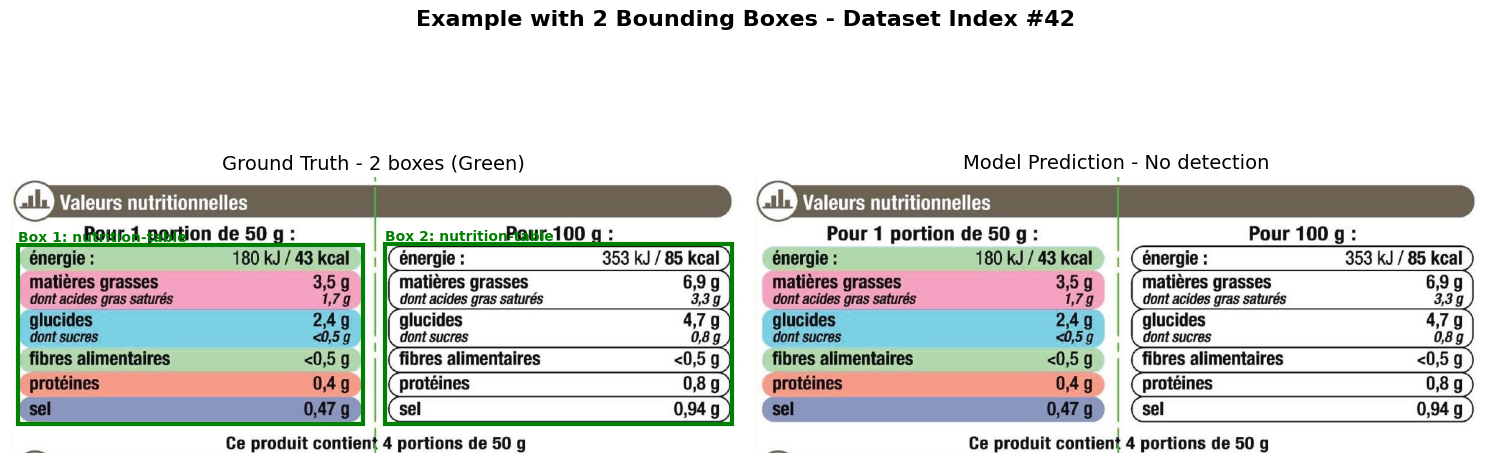


--- Example 2: Dataset index #127 ---
Image size: (2448, 3264)
Number of bboxes: 2
Categories: ['nutrition-table', 'nutrition-table-small-energy']

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: the nutrition table(278,239),(678,996)
Parsed bboxes: {'object': 'the nutrition table', 'bbox': [278, 239, 678, 996]}
Drew bbox in pixels for 'the nutrition table': [680, 780, 1659, 3250]


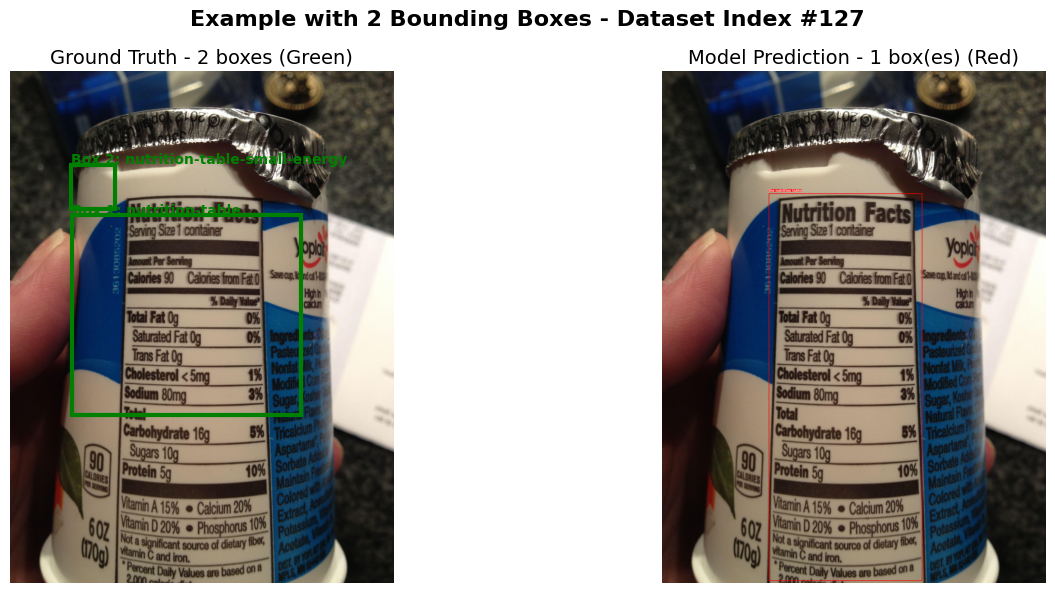

In [12]:
print("\n" + "=" * 60)
print("VISUALIZING EXAMPLES WITH 2 BOUNDING BOXES")
print("=" * 60)

from matplotlib.patches import Rectangle

for i, example_idx in enumerate(examples_with_2_bboxes):
    print(f"\n--- Example {i+1}: Dataset index #{example_idx} ---")
    example = dataset[example_idx]
    image = example['image']
    bboxes = example['objects']['bbox']
    categories = example['objects']['category_name']

    print(f"Image size: {image.size}")
    print(f"Number of bboxes: {len(bboxes)}")
    print(f"Categories: {categories}")

    # Run inference
    print("\nRunning inference...")
    model_response = run_qwen2vl_inference(
        image,
        "Detect the bounding box of the nutrition table."
    )
    print(f"Model response: {model_response}")

    parsed_bboxes = parse_qwen_bbox_output(model_response)
    print(f"Parsed bboxes: {parsed_bboxes}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Ground truth
    axes[0].imshow(image)
    axes[0].set_title(f"Ground Truth - {len(bboxes)} boxes (Green)", fontsize=14)
    axes[0].axis('off')

    pil_width, pil_height = image.size
    for bbox_idx, (bbox, category) in enumerate(zip(bboxes, categories)):
        y_min, x_min, y_max, x_max = bbox
        gt_x1 = int(x_min * pil_width)
        gt_y1 = int(y_min * pil_height)
        gt_x2 = int(x_max * pil_width)
        gt_y2 = int(y_max * pil_height)

        rect = Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                        linewidth=3, edgecolor='green', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(gt_x1, gt_y1-5, f"Box {bbox_idx+1}: {category}",
                    color='green', fontsize=10, weight='bold')

    # Model prediction
    if parsed_bboxes:
        img_with_pred = visualize_bbox_on_image(image, parsed_bboxes, normalize_coords=True)
        axes[1].imshow(img_with_pred)
        num_pred = len(parsed_bboxes) if isinstance(parsed_bboxes, list) else 1
        axes[1].set_title(f"Model Prediction - {num_pred} box(es) (Red)", fontsize=14)
    else:
        axes[1].imshow(image)
        axes[1].set_title("Model Prediction - No detection", fontsize=14)
    axes[1].axis('off')

    plt.suptitle(f"Example with 2 Bounding Boxes - Dataset Index #{example_idx}",
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Visualize Examples with 3 Bounding Boxes


VISUALIZING EXAMPLES WITH 3 BOUNDING BOXES

--- Example 1: Dataset index #65 ---
Image size: (1936, 2592)
Number of bboxes: 3
Categories: ['nutrition-table', 'nutrition-table-small-energy', 'nutrition-table-small-energy']

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: The nutrition table(543,125),(826,335)
Parsed bboxes: {'object': 'The nutrition table', 'bbox': [543, 125, 826, 335]}
Drew bbox in pixels for 'The nutrition table': [1051, 324, 1599, 868]


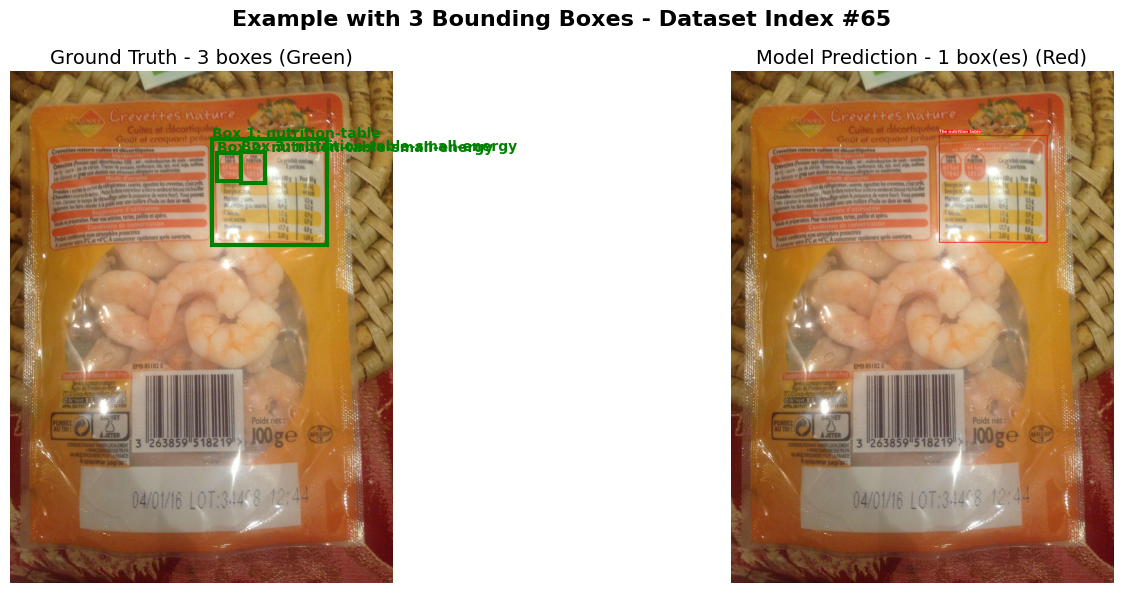


--- Example 2: Dataset index #251 ---
Image size: (3264, 2448)
Number of bboxes: 3
Categories: ['nutrition-table', 'nutrition-table-small-energy', 'nutrition-table-small-energy']

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: the nutrition table(507,385),(715,591)
Parsed bboxes: {'object': 'the nutrition table', 'bbox': [507, 385, 715, 591]}
Drew bbox in pixels for 'the nutrition table': [1654, 942, 2333, 1446]


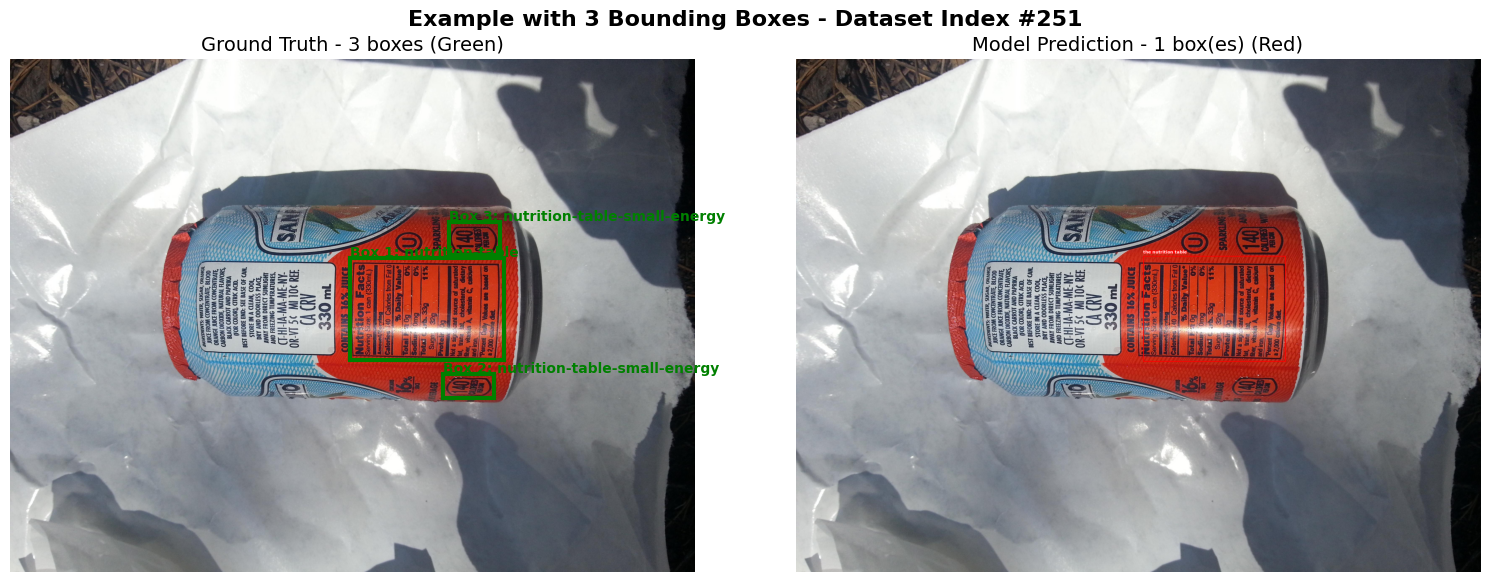

In [13]:
print("\n" + "=" * 60)
print("VISUALIZING EXAMPLES WITH 3 BOUNDING BOXES")
print("=" * 60)

for i, example_idx in enumerate(examples_with_3_bboxes):
    print(f"\n--- Example {i+1}: Dataset index #{example_idx} ---")
    example = dataset[example_idx]
    image = example['image']
    bboxes = example['objects']['bbox']
    categories = example['objects']['category_name']

    print(f"Image size: {image.size}")
    print(f"Number of bboxes: {len(bboxes)}")
    print(f"Categories: {categories}")

    # Run inference
    print("\nRunning inference...")
    model_response = run_qwen2vl_inference(
        image,
        "Detect the bounding box of the nutrition table."
    )
    print(f"Model response: {model_response}")

    parsed_bboxes = parse_qwen_bbox_output(model_response)
    print(f"Parsed bboxes: {parsed_bboxes}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Ground truth
    axes[0].imshow(image)
    axes[0].set_title(f"Ground Truth - {len(bboxes)} boxes (Green)", fontsize=14)
    axes[0].axis('off')

    pil_width, pil_height = image.size
    for bbox_idx, (bbox, category) in enumerate(zip(bboxes, categories)):
        y_min, x_min, y_max, x_max = bbox
        gt_x1 = int(x_min * pil_width)
        gt_y1 = int(y_min * pil_height)
        gt_x2 = int(x_max * pil_width)
        gt_y2 = int(y_max * pil_height)

        rect = Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                        linewidth=3, edgecolor='green', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(gt_x1, gt_y1-5, f"Box {bbox_idx+1}: {category}",
                    color='green', fontsize=10, weight='bold')

    # Model prediction
    if parsed_bboxes:
        img_with_pred = visualize_bbox_on_image(image, parsed_bboxes, normalize_coords=True)
        axes[1].imshow(img_with_pred)
        num_pred = len(parsed_bboxes) if isinstance(parsed_bboxes, list) else 1
        axes[1].set_title(f"Model Prediction - {num_pred} box(es) (Red)", fontsize=14)
    else:
        axes[1].imshow(image)
        axes[1].set_title("Model Prediction - No detection", fontsize=14)
    axes[1].axis('off')

    plt.suptitle(f"Example with 3 Bounding Boxes - Dataset Index #{example_idx}",
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 📝 Summary and Key Insights

### What We Learned:

1. **Tokenizer & Special Tokens**:
   - Qwen2-VL uses many vision-specific tokens
   - Coordinates are in normalized [0, 1000] space
   - Token consistency between tokenizer and model is critical

2. **Model Architecture**:
   - Uses bfloat16 precision
   - Flash Attention 2 for efficiency
   - Embedding dimensions must match tokenizer length

3. **Inference Pipeline**:
   - Messages → Chat Template → Vision Processing → Generation
   - Output can include special tokens or plain text
   - Supports multiple images/videos in one conversation

4. **Pre-trained Capabilities**:
   - Model can detect some objects (like cars)
   - May struggle with nutrition tables (not in training data)
   - Might miss multiple objects in same image
   - Bounding boxes may be inaccurate

### Why Fine-tuning is Needed:

- **Domain Gap**: Nutrition tables are different from general objects
- **Accuracy**: Pre-trained model's boxes are often imprecise
- **Multi-object**: May not detect all nutrition tables in one image
- **Terminology**: Model might use generic terms vs specific "nutrition table"

### Next Steps:

After understanding the model, you're ready to:
1. Prepare training data (see main training notebook)
2. Fine-tune the model on nutrition table dataset
3. Compare pre-trained vs fine-tuned performance
4. Evaluate improvement in accuracy and multi-object detection

📓 **Continue to main training notebook**: `fine_tuning_vlm_for_object_detection_trl.ipynb`